<a href="https://colab.research.google.com/github/OleksandrArtemenko/churn_analysis_porfolio/blob/main/Analysis_of_the_spotify_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation, imports and loading of the data

## Installations

In [ ]:
pip install kagglehub[pandas-datasets]

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


## Imports and data load

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.stats.proportion import proportions_ztest
import itertools
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('muted')

In [ ]:
file_path = "spotify_churn_dataset.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "nabihazahid/spotify-dataset-for-churn-analysis",
    file_path,
)

Using Colab cache for faster access to the 'spotify-dataset-for-churn-analysis' dataset.


In [ ]:
# # Another option in case the direct download from Kaggle does not work
# df = pd.read_csv("spotify_churn_dataset.csv")

In [ ]:
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


## Description of the dataset from the author

Rows: Each row represents a unique Spotify user.

Columns (Features):

user_id → Unique identifier for each user

gender → User gender (Male/Female/Other)

age → User age

country → User location

subscription_type → Type of Spotify subscription (Free, Premium, Family, Student)

listening_time → Minutes spent listening per day

songs_played_per_day → Number of songs played daily

skip_rate → Percentage of songs skipped

device_type → Device used (Mobile, Desktop, Web)

ads_listened_per_week → Number of ads heard per week

offline_listening → Offline mode usage

is_churned → Target variable (0 = Active, 1 = Churned)

# Introduction

Current project will be conducted in order to practice some fundamental skills of data analysis. The dataset has been chosen at the Kaggle website, which has been one of the primary resources for learning data analysis. This dataset is related to the issue of churn, which is a widespread concern for many businesses of different spheres.
The information in the dataset is described as "synthetically generated dataset" for Spotify. It includes different features that characterize clients and their behaviour. Therefore, it may be interesting to analyze influence (or its absence) on the churn status.

## Main tasks

Before the analysis starts, the following steps of the further investigation may be seen:

1.   First of all, it is important to understand current state of this business, mainly different distributions of clients across features;
2.   After that, interactions of different features might be a subject of interest, especially in the context of the target variable (churn);
3.   Finally, some basic model may be chosen to provide predictions of the churn status.




# Exploratory data analysis

## General overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                8000 non-null   int64  
 1   gender                 8000 non-null   object 
 2   age                    8000 non-null   int64  
 3   country                8000 non-null   object 
 4   subscription_type      8000 non-null   object 
 5   listening_time         8000 non-null   int64  
 6   songs_played_per_day   8000 non-null   int64  
 7   skip_rate              8000 non-null   float64
 8   device_type            8000 non-null   object 
 9   ads_listened_per_week  8000 non-null   int64  
 10  offline_listening      8000 non-null   int64  
 11  is_churned             8000 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 750.1+ KB


General overview of the data shows that there are 8000 records in the dataset, and there are no null values. There are both numeric (age, listening_time, songs_played_per_day, skip_rate, ads_listened_per_week) and categorical data (user_id, gender, country, subscription_type, device_type, offline_listening, is_churned).

It may be noticed that some features (offline_listening, is_churned) appear to have numeric format of int, but conceptually they are categorical.
We may change their types for more proper visual treatment in the future. We will leave an initial copy with numeric values as well, because we might need it for predictive analytics later.
We could change object datatype to category as well, but since the dataset is relatively small, it is not critical for performance efficiency, so we will leave them as it is for now.

In [ ]:
df_with_numeric = df.copy()

In [ ]:
df['offline_listening'] = df['offline_listening'].astype('category')
df['is_churned'] = df['is_churned'].astype('category')

In [ ]:
df.drop(columns=['user_id']).describe()

,age,listening_time,songs_played_per_day,skip_rate,ads_listened_per_week
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,37.662125,154.068250,50.127250,0.300127,6.943875
std,12.740359,84.015596,28.449762,0.173594,13.617953
min,16.000000,10.000000,1.000000,0.000000,0.000000
25%,26.000000,81.000000,25.000000,0.150000,0.000000
50%,38.000000,154.000000,50.000000,0.300000,0.000000
75%,49.000000,227.000000,75.000000,0.450000,5.000000
max,59.000000,299.000000,99.000000,0.600000,49.000000


From the first glace on the general numeric data, we can see that an average customer is 37 years old with average of 50 played songs and 154 minutes of listening per day with 30% of skipped songs. We might also see that distributions of age, listening_time, songs_played_per_day and skip_rate are likely to be smooth, based on values of quartiles. As for ads, most of customers do not have them, likely preferring ad-less subscription plans.

In [ ]:
df.describe(include=['object', 'category']).transpose()

,count,unique,top,freq
gender,8000,3,Male,2691
country,8000,8,AU,1034
subscription_type,8000,4,Premium,2115
device_type,8000,3,Desktop,2778
offline_listening,8000,2,1,5982
is_churned,8000,2,0,5929


From the overview of the categorical data, most of features are balanced, based on top frequencies and count of unique categories. Only two categories (offline_listening and is_churned) appear to be imbalanced.

## Exploration of customers

First of all, let's start with general distributions and countplots of features without interaction between each other. Thus, we will get more accurate description of who are our customers.

In [ ]:
numeric_cols = df.drop(columns=['user_id']).select_dtypes(include='number').columns
print(numeric_cols)

Index(['age', 'listening_time', 'songs_played_per_day', 'skip_rate',
       'ads_listened_per_week'],
      dtype='object')


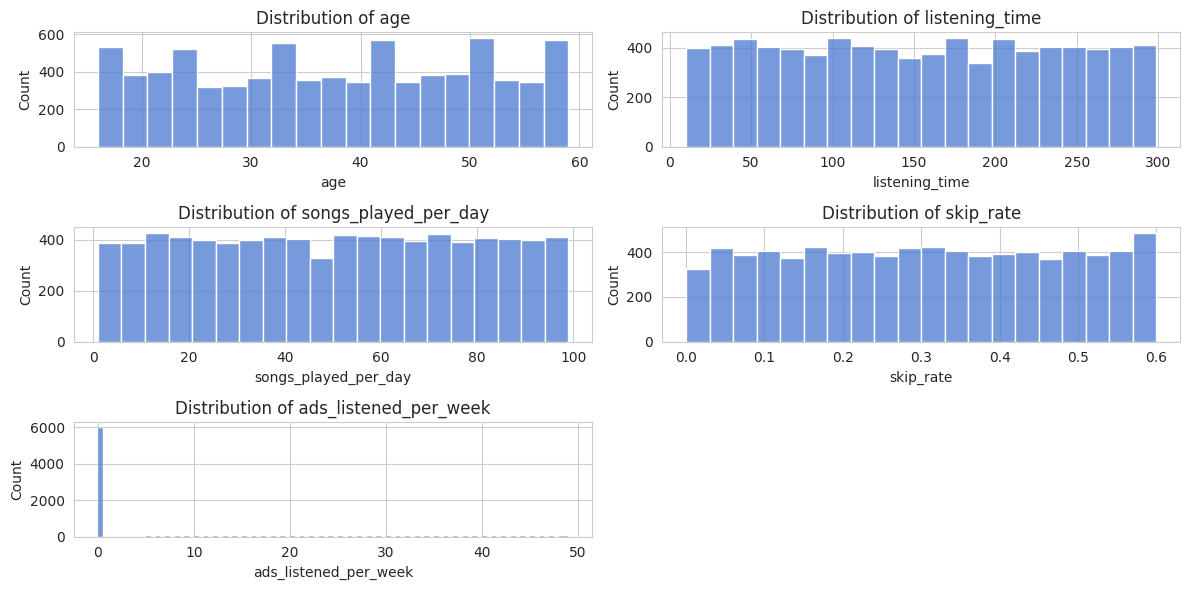

In [ ]:
nrows = math.ceil(len(numeric_cols) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

for index, column in enumerate(numeric_cols):
  row = index // ncols
  col = index % ncols
  sns.histplot(df[column], ax=axes[row][col])
  axes[row, col].set_title(f"Distribution of {column}")

for j in range(len(numeric_cols), nrows * ncols):
    row = j // ncols
    col = j % ncols
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

As can be seen from the distribution charts, most distributions are indeed smooth and are close to uniform, except for ads_listened_per_week one. This means that our previous assumption on the average customer of 37 years old with average of 50 played songs and 154 minutes of listening per day with 30% of skipped songs is not representative for most customers, because values are not concentrated near the mean, i.e. distributions are not normal.

Some age ranges like early 30-s, 40-s, 50-s etc. have more customers in them, but there is no particular trend. There are no clear outliers as well.
As for ads_listened_per_week, the chart looks this way due to imbalance in values, since most of customers have zero ads. Let's check that below.

In [ ]:
df['ads_listened_per_week'].value_counts().sort_index()

,count
ads_listened_per_week,
0,5982
5,42
6,38
7,37
8,43
9,44
10,42
11,43
12,46


Indeed, around 75% of customers do not have ads. Let's try to change the scaling so that the situation with the remaining clients who watch ads would become more clear.

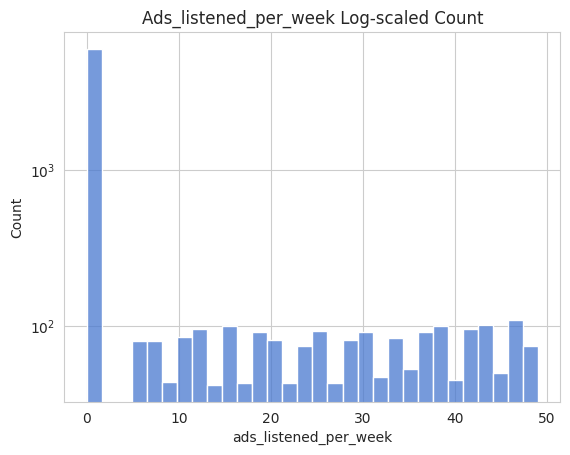

In [ ]:
sns.histplot(df['ads_listened_per_week'], bins=30)
plt.yscale("log")
plt.title(f"Ads_listened_per_week Log-scaled Count")
plt.show()

Thus, we may see that the remaining 25% of clients watch between 5 and 50 ads per week.

After having viewed charts of numeric values, let's have a look on overview charts of categorical features.

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['gender', 'country', 'subscription_type', 'device_type',
       'offline_listening', 'is_churned'],
      dtype='object')


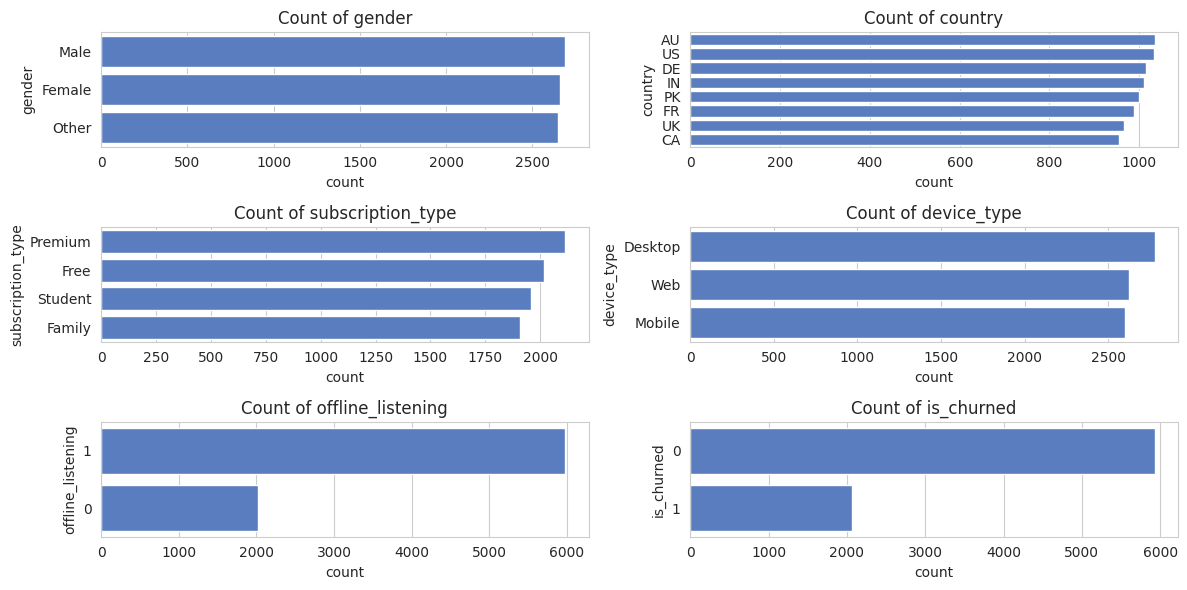

In [ ]:
nrows = math.ceil(len(numeric_cols) / 2)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))

for index, column in enumerate(categorical_cols):
  row = index // ncols
  col = index % ncols
  order = df[column].value_counts().index
  sns.countplot(df[column], ax=axes[row][col], order=order)
  axes[row, col].set_title(f"Count of {column}")

for j in range(len(categorical_cols), nrows * ncols):
    row = j // ncols
    col = j % ncols
    axes[row, col].axis("off")

plt.tight_layout()
plt.show()

As can be seen, gender, country, subscription_type and device_type are rather balanced categories. It might be highlighted that Premium is the most popular subscription that is favorable for the company.

Right away, let's check how different types of subscriptions are distributed across groups. It may be useful for general business understanding and for targeting purposes.

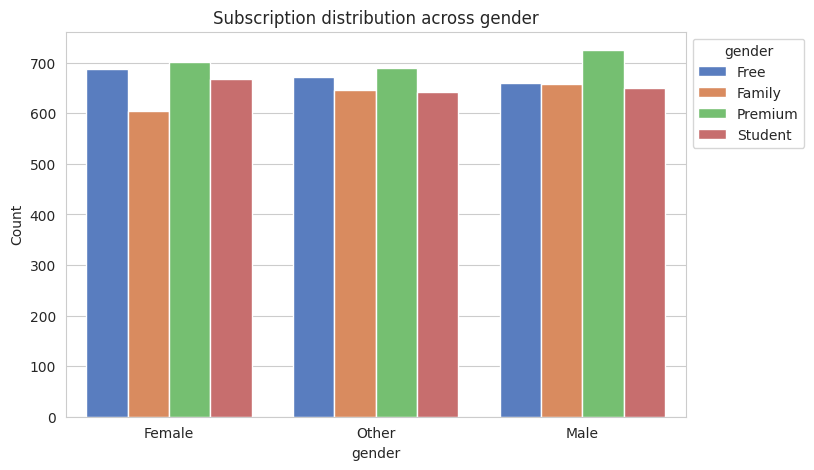

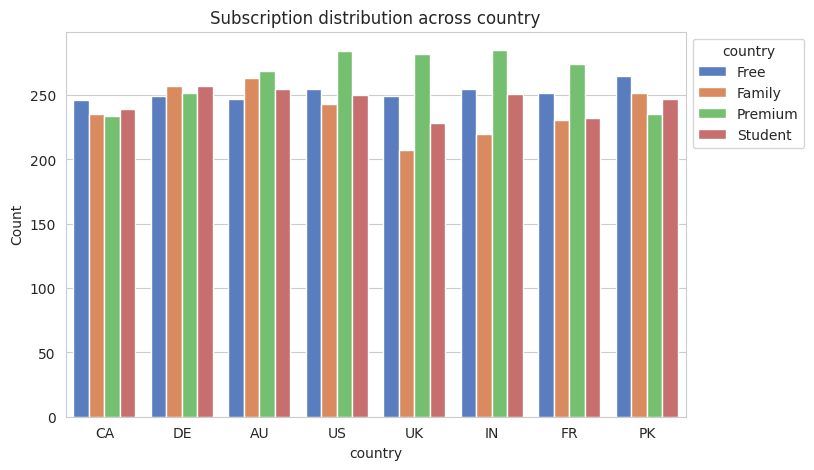

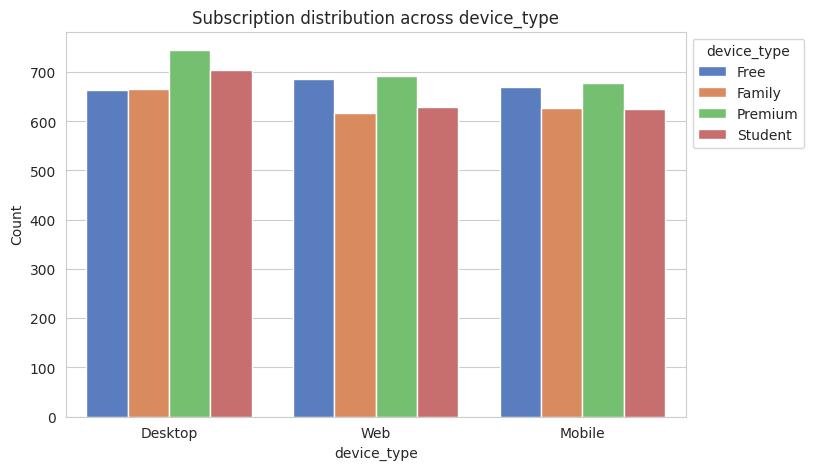

In [ ]:
col_with_sub = ['gender', 'country', 'device_type']

for column in col_with_sub:
  plt.figure(figsize=(8,5))
  sns.countplot(data=df, x=f"{column}", hue='subscription_type')
  plt.title(f"Subscription distribution across {column}")
  plt.ylabel("Count")

  plt.legend(title=f"{column}", bbox_to_anchor=(1,1))

plt.show()

As it is visible, male customers are slightly more inclined to purchase paid plans (highest Premium and lowest Free).

As for countries chart, we may see relatively rich (UK, US, IN, FR) and poor markets.

On the device chart, it is clear that desktop users are more prone to purchase paid plans.

Of course, it should be considered that the volume of sample is low, and we don't know whether it is representative or not. In practice, much more data would be needed.

## Exploration of customers' activities

Now let's move on to interaction of features, which may show us some aspects of customers' behaviour.

First of all, let's check whether there is any pattern between listening time and skip rate.

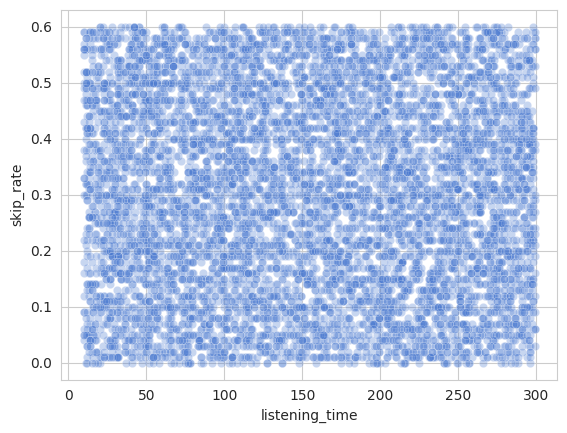

In [ ]:
sns.scatterplot(data=df, x='listening_time', y='skip_rate', alpha=0.3)
plt.show()

As can be seen from the chart, there is no visible correlation between listening and skipping.

Apart from that, it might be interesting to see whether there are any patterns between listening time and experiencing ads.

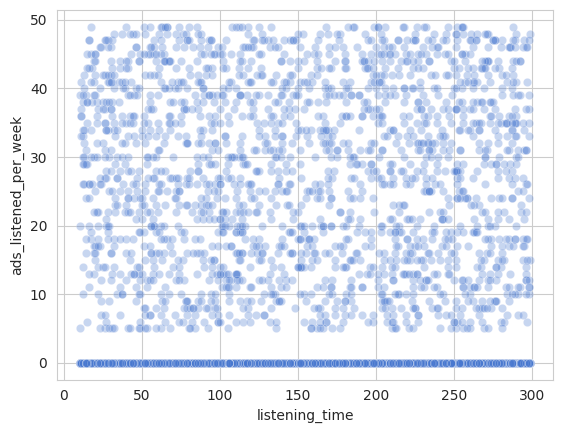

In [ ]:
sns.scatterplot(data=df, x='listening_time', y='ads_listened_per_week', alpha=0.3)
plt.show()

Again, no clear patterns can be seen. Let's double check that by assessing correlation between numeric features.

In [ ]:
correlation_matrix = df[numeric_cols].corr()

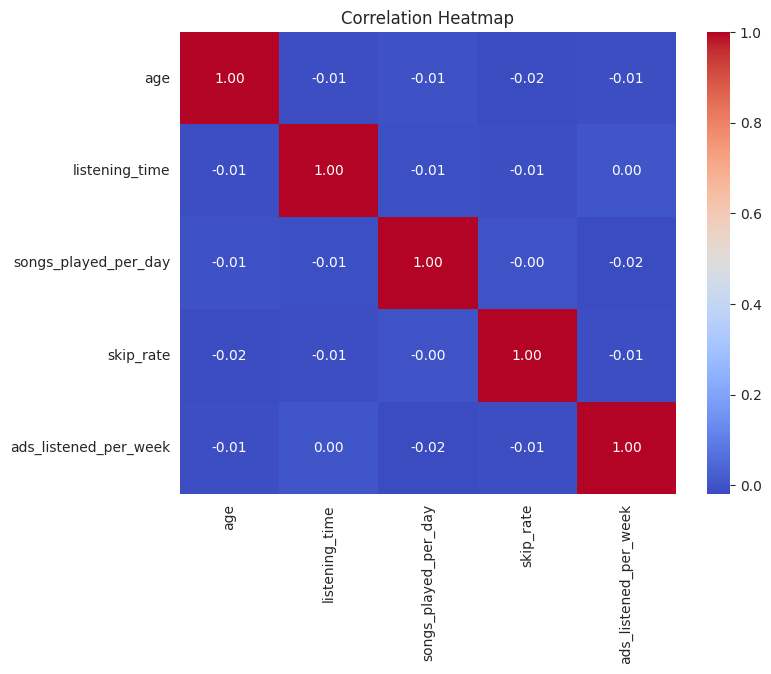

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

Basically, there is no observed linear correlation.

Moving on, let's investigate behaviour of customers across different categories, mainly age (there may still be some trends for particular age groups), gender and subscription_type. We would assess listening_time and skip_rate as activities and will try to describe some patterns.

First of all, it is necessary to categorize age by dividing it into bins.

In [ ]:
print(f"Min: {df["age"].min()}, Max: {df["age"].max()}")

Min: 16, Max: 59


Concerning minimal and maximal age, let's divide this feature into 4 bins.

In [ ]:
bins = [16, 30, 40, 50, 60]
labels = ["16-29", "30-39", "40-49", "50-59"]

df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels, include_lowest=True, right=False)

In [ ]:
df["age_group"].value_counts()

,count
age_group,
16-29,2478
40-49,1852
50-59,1852
30-39,1818


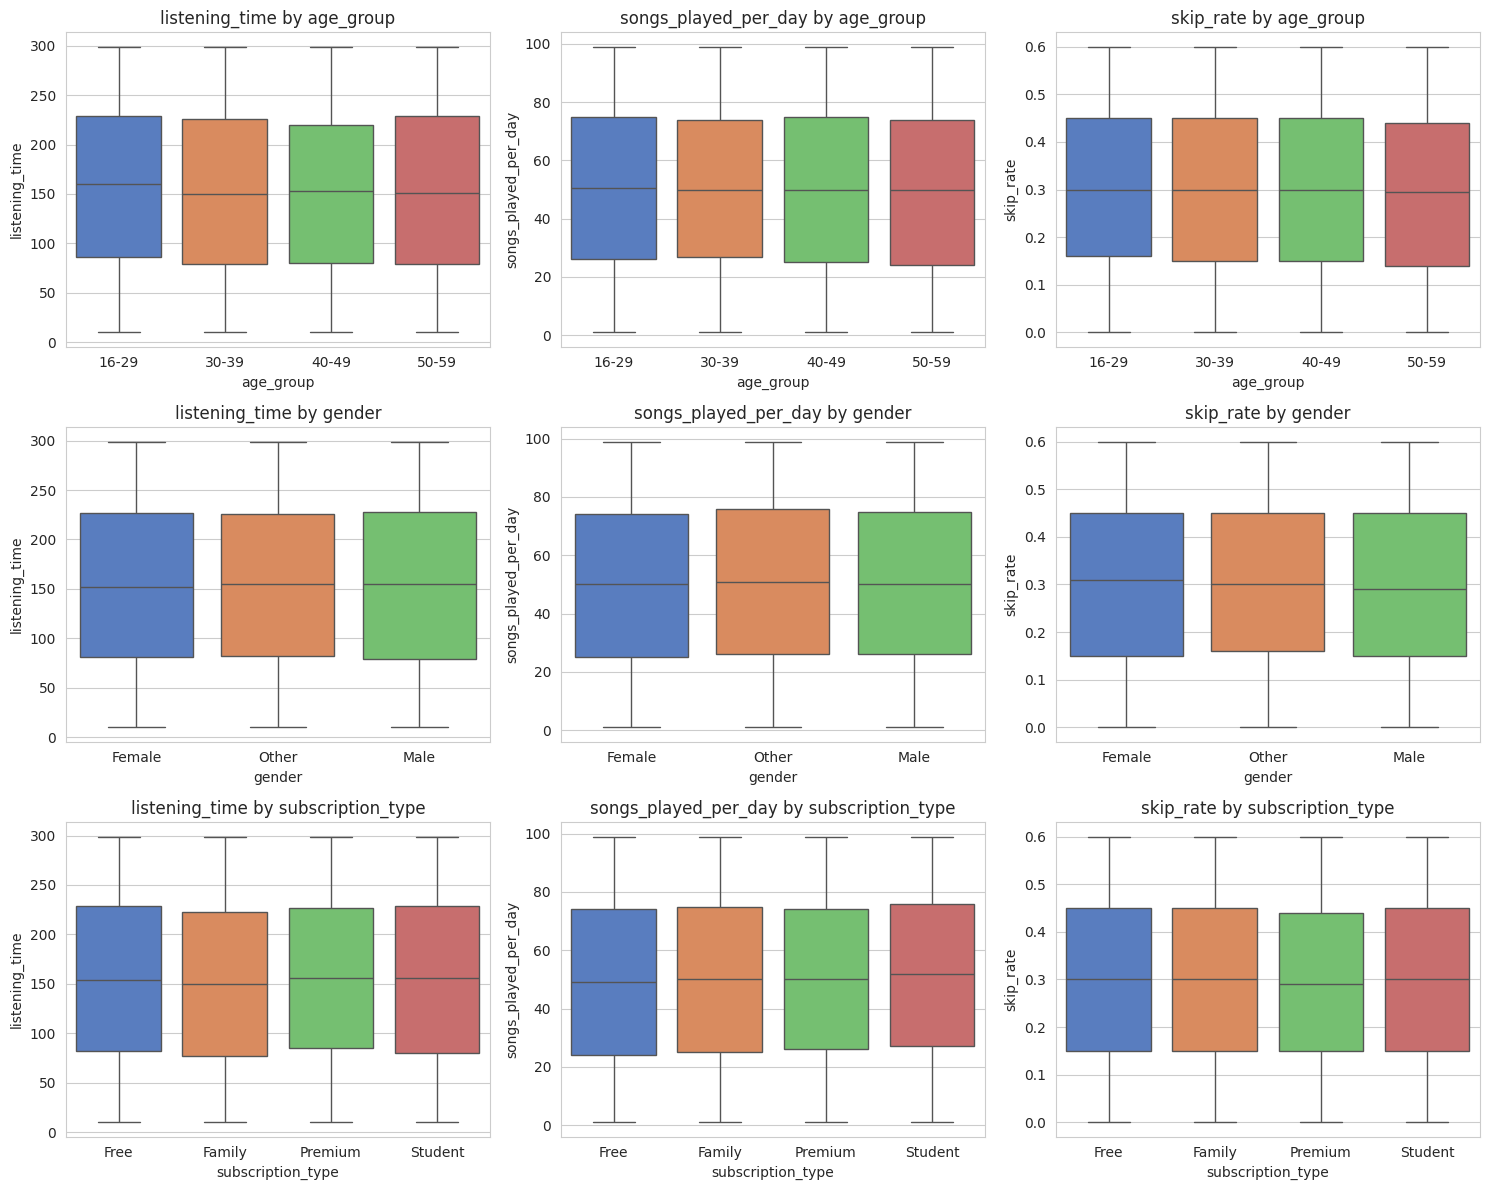

In [ ]:
col_categories = ['age_group', 'gender', 'subscription_type']
col_measures = ['listening_time', 'songs_played_per_day', 'skip_rate']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for index, (category, measure) in enumerate([(c, m) for c in col_categories for m in col_measures]):
    ax = axes[index]
    sns.boxplot(data=df, x=category, y=measure, ax=ax, hue=category)
    ax.set_title(f"{measure} by {category}")
    ax.set_xlabel(category)
    ax.set_ylabel(measure)

plt.tight_layout()
plt.show()

As we can see, there are no crucial differences in the observed activities within the chosen categories. It may be seen that younger age has had a slighly higher listening time, but it may be surprising that it is not so far from older ages. Apart from that, skip rate for Premium is slightly lower than for other subscription types.

Overall, we could see that in context of interaction with the service (time of listening, amount of songs, rate of skippage), behaviour of customers is rather similar across different categories. Therefore, it may be a good way to segment such customers in a simple way, for example, by subscription type.

## Churn analysis

As we have explored the questions of who our customers are, how they are classified and what they are doing, it is time to move on to one of the most important aspects of every business, which is customer churn.

First of all, let's investigate distribution of churned and non-churned clients within other categories.

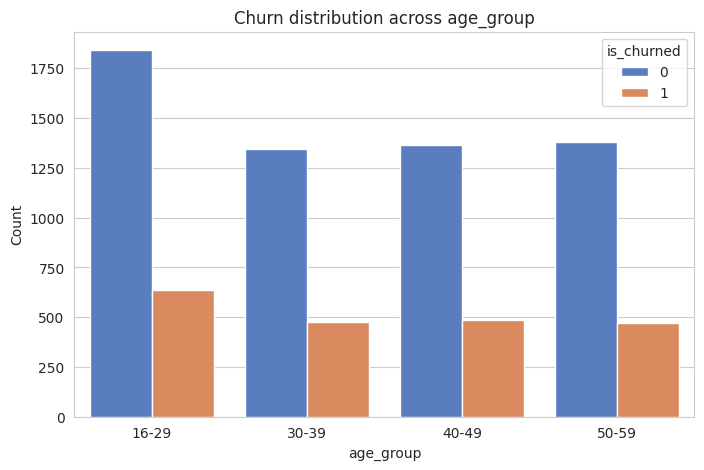

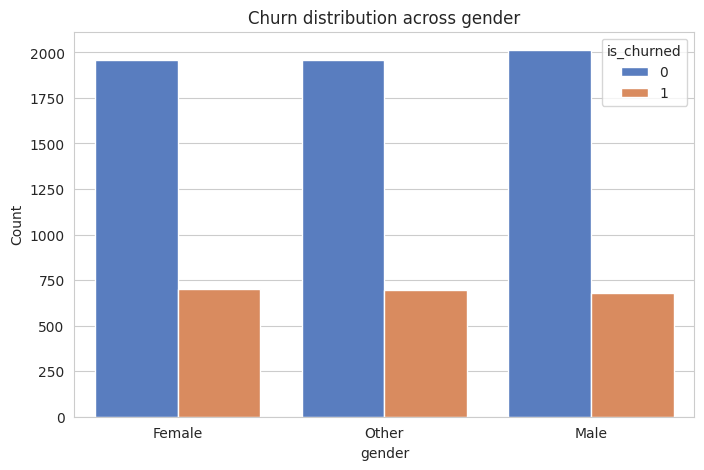

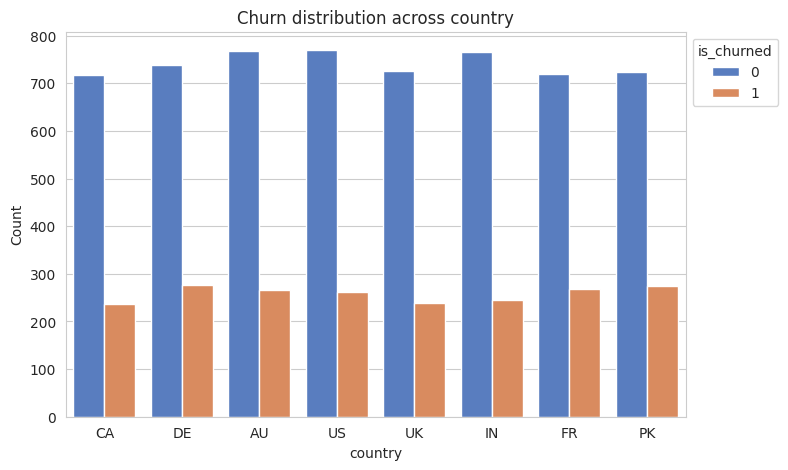

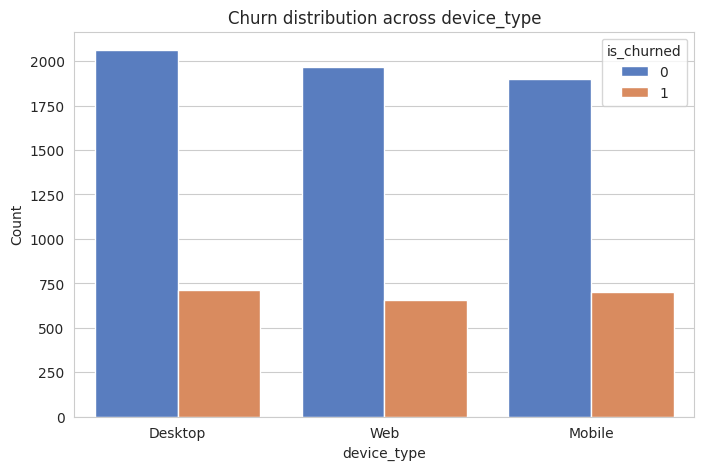

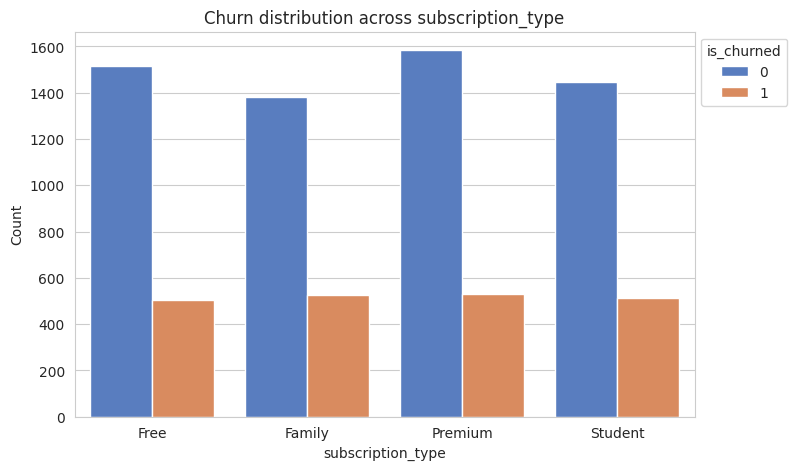

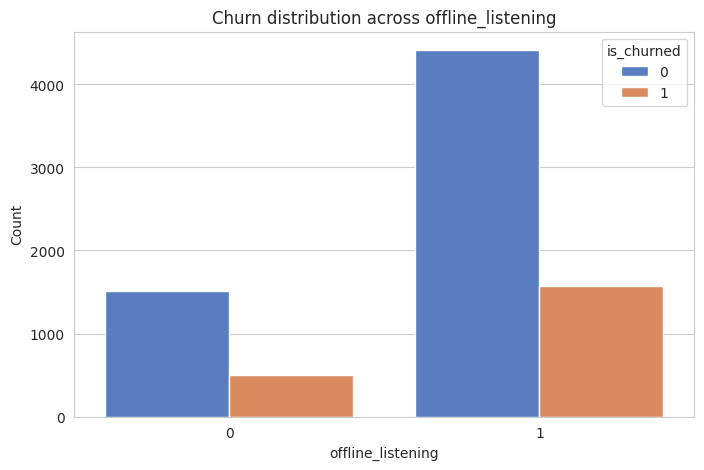

In [ ]:
col_with_churn = ['age_group', 'gender', 'country', 'device_type', 'subscription_type', 'offline_listening']

for column in col_with_churn:
  plt.figure(figsize=(8,5))
  sns.countplot(data=df, x=f"{column}", hue='is_churned')
  plt.title(f"Churn distribution across {column}")
  plt.ylabel("Count")

  plt.legend(title="is_churned", bbox_to_anchor=(1,1))

plt.show()

Based on visualization, we do not see crucial imbalances of churn within groups. However, there are still some observation to highlight, such as:

*   Differences in churn ratios between countries, mainly higher ratio for PK, DE and FR, and lower for IN, UK and CA;
*   Family subscription type seems to have higher churn ratio comparing to other.

Apart from that, let's investigate if observed differences can be considered as statistically significant.

In [ ]:
df['is_churned'] = df['is_churned'].astype('int')

In [ ]:
# Function for conducting one z-test between two subgroups
def conduct_ztest(category, sub1, sub2, df=df):
  success = [df[(df[category] == sub1) & (df['is_churned'] == 1)].shape[0], df[(df[category] == sub2) & (df['is_churned'] == 1)].shape[0]]
  obs = [df[df[category] == sub1].shape[0], df[df[category] == sub2].shape[0]]

  stat, p_value = proportions_ztest(success, obs)

  return p_value

In [ ]:
# Function for conducting z-tests for all combination of subgroups within one group
def ztest_all_pairs(category):
    results = []
    unique_categories = df[category].dropna().unique()

    for sub1, sub2 in itertools.combinations(unique_categories, 2):
        p = conduct_ztest(category, sub1, sub2)
        results.append({
            "category": category,
            "group_1": sub1,
            "group_2": sub2,
            "p_value": p
        })

    return pd.DataFrame(results)

**Age**

In [ ]:
df.groupby('age_group', observed=True)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False).reset_index(drop=True)

,age_group,is_churned
0,40-49,0.263499
1,30-39,0.260726
2,16-29,0.256659
3,50-59,0.255400


In [ ]:
ztest_all_pairs('age_group').sort_values(by='p_value').reset_index(drop=True)

,category,group_1,group_2,p_value
0,age_group,50-59,40-49,0.573926
1,age_group,16-29,40-49,0.611484
2,age_group,50-59,30-39,0.712338
3,age_group,30-39,16-29,0.763492
4,age_group,30-39,40-49,0.848549
5,age_group,50-59,16-29,0.925185


Conclusion on **age**: no significant difference between subgroups has been observed, result may not be considered as statistically significant.

**Gender**

In [ ]:
df.groupby('gender', observed=True)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False).reset_index(drop=True)

,gender,is_churned
0,Female,0.262881
1,Other,0.261887
2,Male,0.251951


In [ ]:
ztest_all_pairs('gender').sort_values(by='p_value').reset_index(drop=True)

,category,group_1,group_2,p_value
0,gender,Female,Male,0.360569
1,gender,Other,Male,0.405998
2,gender,Female,Other,0.934397


Conclusion on **gender**: no significant difference between subgroups has been observed, result may not be considered as statistically significant.

**Countries**

In [ ]:
df.groupby('country', observed=True)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False).reset_index(drop=True)

,country,is_churned
0,PK,0.275275
1,DE,0.272906
2,FR,0.271992
3,AU,0.257253
4,US,0.253876
5,CA,0.248428
6,UK,0.247412
7,IN,0.243323


In [ ]:
ztest_all_pairs('country').sort_values(by='p_value').reset_index(drop=True)

,category,group_1,group_2,p_value
0,country,IN,PK,0.102153
1,country,DE,IN,0.128163
2,country,IN,FR,0.142655
3,country,UK,PK,0.160028
4,country,CA,PK,0.177502
5,country,DE,UK,0.196252
6,country,UK,FR,0.215343
7,country,CA,DE,0.216472
8,country,CA,FR,0.236730
9,country,US,PK,0.274289


Conclusion on **countries**: there is some difference between top group of countries (PK, DE, FR) and bottom ones (CA, UK, IN), and the results are more close to statistical significance threshold.

**Subscription types**

In [ ]:
df.groupby('subscription_type', observed=True)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False).reset_index(drop=True)

,subscription_type,is_churned
0,Family,0.275157
1,Student,0.261868
2,Premium,0.250591
3,Free,0.249257


In [ ]:
ztest_all_pairs('subscription_type').sort_values(by='p_value').reset_index(drop=True)

,category,group_1,group_2,p_value
0,subscription_type,Free,Family,0.065043
1,subscription_type,Family,Premium,0.076913
2,subscription_type,Family,Student,0.351167
3,subscription_type,Free,Student,0.361918
4,subscription_type,Premium,Student,0.409913
5,subscription_type,Free,Premium,0.921112


Conclusion on **subscription types**: there is some difference between Family and more successful types in this context (Free, Premium), and the results have almost reached a threshold of 0.05 for statistical significance.

**Offline listening**

In [ ]:
df.groupby('offline_listening', observed=True)['is_churned'].mean().reset_index().sort_values(by='is_churned', ascending=False).reset_index(drop=True)

,offline_listening,is_churned
0,1,0.262120
1,0,0.249257


In [ ]:
ztest_all_pairs('offline_listening').sort_values(by='p_value').reset_index(drop=True)

,category,group_1,group_2,p_value
0,offline_listening,0,1,0.253974


Conclusion on **offline listening**: there is some observable difference between churn of those who use offline listening and those who do not, but the result cannot be considered as statistically significant.

**Overall conclusion on oberved differences and statistical significance:** size of the sample (8000) might be insufficient for such kind of analysis, and there is no information concerning how this data has been collected to assess its representative power. With this in mind, we can only treat these results (like higher churn in some countries or higher churn for Family subscription) as possible differences that require further investigation on bigger or more representative samples

Apart from differences in churn by categories, let's additionally explore possible differences of customers' behaviour across the churn status.

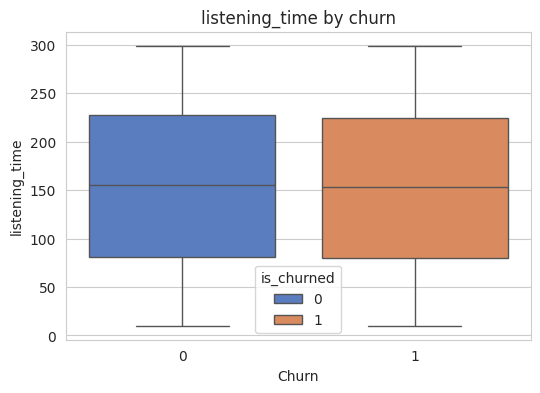

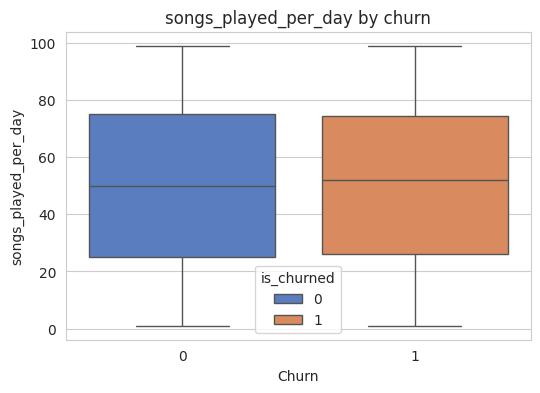

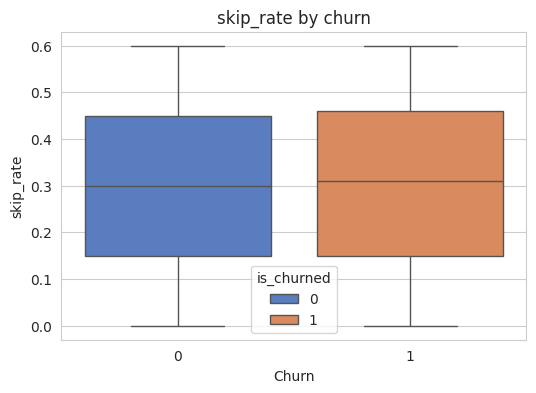

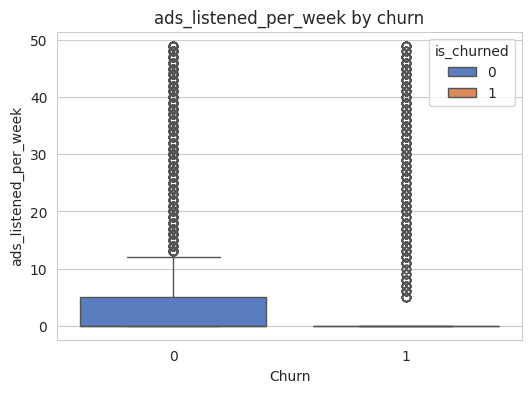

In [ ]:
col_measures_churn = ['listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']

for measure in col_measures_churn:
  plt.figure(figsize=(6,4))
  sns.boxplot(data=df, x='is_churned', y=measure, hue='is_churned')
  plt.title(f"{measure} by churn")
  plt.ylabel(f"{measure}")
  plt.xlabel(f"Churn")

plt.show()

Based on the charts, activities of customers seem to be quite similar for both churn statuses. Due to imbalances between customers who have listened to ads and those who have not, the appropriate chart cannot be used for any conclusions. Therefore, let's conduct further calculations on mean values of activities across churn status.

In [ ]:
df.groupby('is_churned', observed=False)[['listening_time', 'songs_played_per_day', 'skip_rate']].agg(['mean', 'std', 'count'])

listening_time                  songs_played_per_day             \
                     mean        std count                 mean        std   
is_churned                                                                   
0              154.446787  84.323276  5929            49.970653  28.480374   
1              152.984549  83.139146  2071            50.575567  28.364024   

                 skip_rate                  
           count      mean       std count  
is_churned                                  
0           5929  0.298474  0.173328  5929  
1           2071  0.304862  0.174310  2071

As we can see, mean values and standard deviations are quite similar, so there are no observed differences in behaviour for churned and non-churned.

As for the amount of listened ads, let's consider only those customers who are subject to ads due to the subscription plan.

In [ ]:
df[df['ads_listened_per_week'] > 0].groupby('is_churned', observed=False)['ads_listened_per_week'].agg(['mean', 'std', 'count'])

,mean,std,count
is_churned,,,
0,27.246865,13.006341,1515
1,28.373757,12.885779,503


As can be seen, the differences are also insignificant, especially concerning this feature is calculated for the period of a week.

Therefore, there is no point to calculate statistical significance for activities, because, based on this sample, the behaviour does not change across the churn status.

# Churn prediction

In this section we will try several models to see if we manage to gain any predictive power. First of all, let's start with preparation of the data, mainly encoding categorical features, splitting into train and test, scaling numeric features.

In [ ]:
X = df_with_numeric.drop(columns=['user_id', 'is_churned'])
y = df_with_numeric['is_churned']

In [ ]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
results = []

In addition, it is more convenient to define functions for visualizing the results and storing the information about efficiency of different models.

In [ ]:
def show_results(y_pred):
  print(classification_report(y_test, y_pred))

  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5,4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=["Predicted: No Churn", "Predicted: Churn"],
              yticklabels=["Actual: No Churn", "Actual: Churn"])

  plt.title("Confusion Matrix")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")
  plt.show()

In [ ]:
def record_results(model_name, y_pred):
  results.append({'model': model_name,
                  'precision': round(precision_score(y_test, y_pred), 4),
                  'recall': round(recall_score(y_test, y_pred), 4)})

First of all, let's start with **Logistic Regression**.

In [ ]:
log_reg = LogisticRegression(max_iter=1000, solver='liblinear', class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

              precision    recall  f1-score   support

           0       0.75      0.53      0.62      1186
           1       0.27      0.49      0.34       414

    accuracy                           0.52      1600
   macro avg       0.51      0.51      0.48      1600
weighted avg       0.62      0.52      0.55      1600



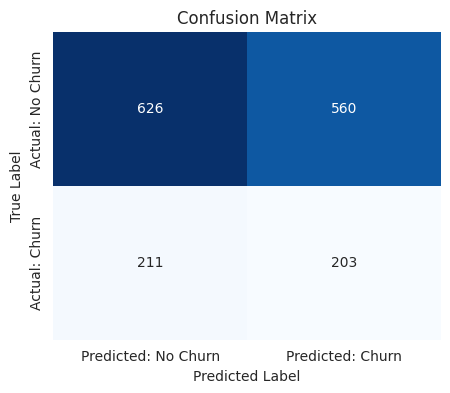

In [ ]:
y_pred = log_reg.predict(X_test_scaled)
show_results(y_pred)

In [ ]:
record_results("Logistic Regression", y_pred)

As can be seen, the model predicts around the half of both variables, which may be fine as some kind of a starting filter, but not appropriate as the final predictor.

Let's try **Decision Tree** as well.

In [ ]:
tree_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    class_weight="balanced",
    random_state=42
)
tree_clf.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

              precision    recall  f1-score   support

           0       0.75      0.47      0.58      1186
           1       0.26      0.55      0.36       414

    accuracy                           0.49      1600
   macro avg       0.51      0.51      0.47      1600
weighted avg       0.62      0.49      0.52      1600



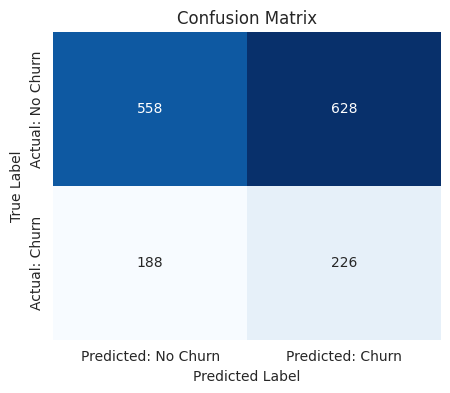

In [ ]:
y_pred = tree_clf.predict(X_test_scaled)
show_results(y_pred)

In [ ]:
record_results("Decision Tree Classifier", y_pred)

This model performs a bit better comparing to the Logistic Regression, but not by much. It catches around 55% of churn, but the drawback is that many good clients get misclassified.

Next model is **Random Forest.**

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)

rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.74      0.99      0.85      1186
           1       0.38      0.01      0.03       414

    accuracy                           0.74      1600
   macro avg       0.56      0.50      0.44      1600
weighted avg       0.65      0.74      0.64      1600



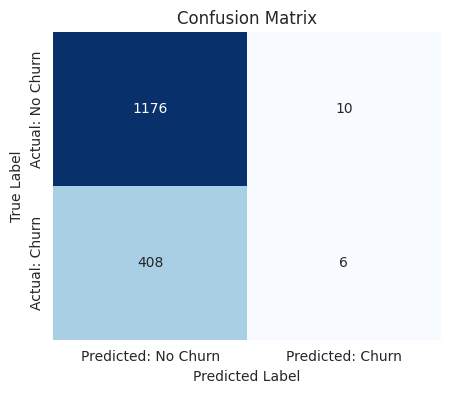

In [ ]:
y_pred = rf_clf.predict(X_test_scaled)
show_results(y_pred)

As we can see, this model does not distinguish among the classes, labeling almost every client as non-churn.

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      1186
           1       0.30      0.35      0.32       414

    accuracy                           0.62      1600
   macro avg       0.53      0.53      0.53      1600
weighted avg       0.64      0.62      0.63      1600



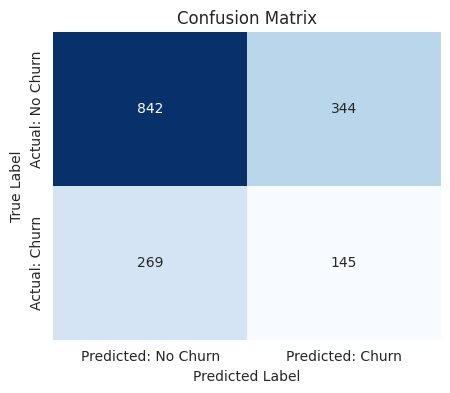

In [ ]:
y_pred_proba = rf_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_custom = (y_pred_proba >= 0.3).astype(int)
show_results(y_pred_custom)

If the threshold of classification gets changed, performance gets better either, but still remaining worse than Logistic Regression and Decision Tree.

In [ ]:
record_results("Random Forest with 0.3 thres", y_pred_custom)

At last, let's try **CatBoost** model. Its preprocessing pipeline slightly differs from the already implemented models, so train-test split has to be performed again.

In [ ]:
numeric_features = ['age', 'listening_time', 'songs_played_per_day', 'skip_rate', 'ads_listened_per_week']
categorical_features = ['gender', 'subscription_type', 'country', 'offline_listening']

X = df_with_numeric[numeric_features + categorical_features]
y = df_with_numeric['is_churned']

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


for col in categorical_features:
    X_train_cb[col] = X_train_cb[col].astype(str)
    X_test_cb[col] = X_test_cb[col].astype(str)

cat_features_idx = [X.columns.get_loc(col) for col in categorical_features]


cb_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric='BalancedAccuracy',
    class_weights=[1, 3],
    random_seed=42,
    verbose=500
)


cb_clf.fit(X_train_cb, y_train_cb, cat_features=cat_features_idx, eval_set=(X_test_cb, y_test_cb))

0:	learn: 0.5258423	test: 0.4981507	best: 0.4981507 (0)	total: 85.4ms	remaining: 42.6s
499:	learn: 0.8181866	test: 0.5087413	best: 0.5229021 (280)	total: 6.83s	remaining: 0us

bestTest = 0.5229020538
bestIteration = 280

Shrink model to first 281 iterations.


              precision    recall  f1-score   support

           0       0.76      0.53      0.63      1186
           1       0.28      0.51      0.36       414

    accuracy                           0.53      1600
   macro avg       0.52      0.52      0.49      1600
weighted avg       0.63      0.53      0.56      1600



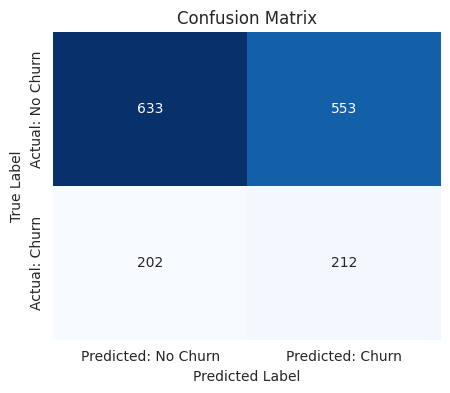

In [ ]:
y_pred = cb_clf.predict(X_test_cb)
show_results(y_pred)

In [ ]:
record_results("CatBoost", y_pred)

As visible from the results, recall on the churn group is around 51%, which is similar to results of two other working models - Logistic Regression and Decision Tree.

Now, let's see the results of all models.

In [ ]:
all_models = pd.DataFrame(results)
all_models

,model,precision,recall
0,Logistic Regression,0.2661,0.4903
1,Decision Tree Classifier,0.2646,0.5459
2,Random Forest with 0.3 thres,0.2965,0.3502
3,CatBoost,0.2771,0.5121


Based on the results, Decision Tree Classifiermay be considered as a slightly more successful one due to the highest recall ratio. Let's also look at feature importances of this model.

                      Feature  Importance
3                   skip_rate    0.339501
0                         age    0.307357
2        songs_played_per_day    0.250974
1              listening_time    0.060100
4       ads_listened_per_week    0.042068
5           offline_listening    0.000000
6                 gender_Male    0.000000
7                gender_Other    0.000000
8                  country_CA    0.000000
9                  country_DE    0.000000
10                 country_FR    0.000000
11                 country_IN    0.000000
12                 country_PK    0.000000
13                 country_UK    0.000000
14                 country_US    0.000000
15     subscription_type_Free    0.000000
16  subscription_type_Premium    0.000000
17  subscription_type_Student    0.000000
18         device_type_Mobile    0.000000
19            device_type_Web    0.000000


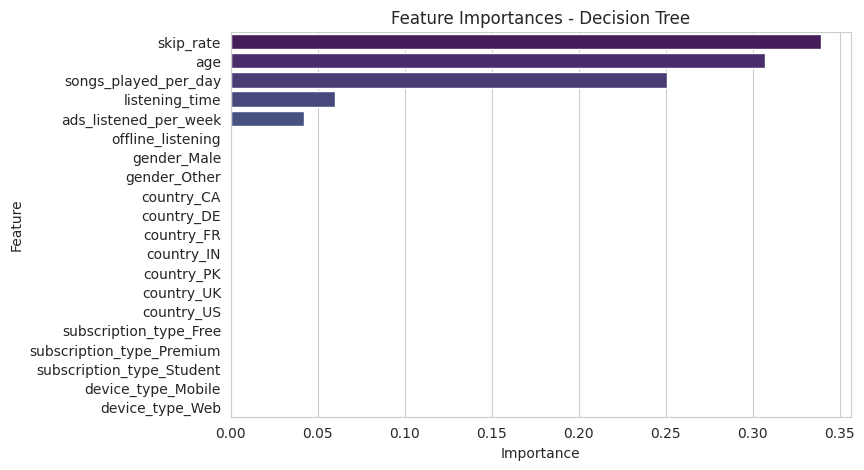

In [ ]:
importances = tree_clf.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feat_imp, palette="viridis", hue="Feature")
plt.title("Feature Importances - Decision Tree")
plt.show()

As might be seen, this model has found all purely numeric features as useful for the process of prediction, with skip_rate and age considered more important than the others.

Looking at overall results, it may be concluded that the Decision Tree Classifier	has shown the best performance, but without significant edge on the other models, recalling around 55% of churn clients.

As overall conclusive thoughts on this section in the context of churn prediction, there are the following:

*   More data, both from the point of volume and from the point of features, might be needed in case there is a task to get a reliable predictive model;
*   Currently available features do not have enough predictive power. Results of EDA support this, as we could not see significant differences of churn between groups and behaviour of churn and non-churn customers.



# General conclusion

Based on all sections of this project, the following conclusions may be made:



*   Most features have uniform distribution. Perhaps for this reason, both EDA and predictive analytics have not produced highly significant revelations. It may be said that clients of different segments look "homogeneous" in terms of activities;
*   It is better to collect more data or add more features to get more distinct segments and try to acquire models with more predictive power;
*   EDA has provided general and detailed overviews of the data, and it has got possible to know main aspects of the business within the provided features;
*   Predicting the churn status with different models has not resulted in finding the highly accurate one, but some of them may be appropriate for starting filtering in order to reveal clients with higher probability of churn.